# Input Modeling for Warehouse Task Arrivals

This notebook models **Task Interarrival Time (seconds)** for the warehouse demand process.

Significance: interarrival times control agent density on the floor; higher density increases collision/congestion risk and stresses MAPF policies.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set_theme(style='whitegrid')

In [2]:
csv_path = '../data/task_demand.csv'
df = pd.read_csv(csv_path)
df.head()

,Task_ID,Timestamp,Interarrival_Time,Regime
0,1,6.380,6.380,base
1,2,10.338,3.958,base
2,3,13.044,2.706,base
3,4,17.543,4.499,base
4,5,43.676,26.133,base


In [3]:
# Build a homogeneous sample for classical I.I.D. fitting
# We keep only base-regime intervals that do not cross rush/lunch boundaries.
RUSH_START, RUSH_END = 1800.0, 7200.0
LUNCH_START, LUNCH_END = 14400.0, 16200.0
HORIZON = 28800.0

def base_segment_id(t: float) -> int:
    if 0 <= t < RUSH_START:
        return 1
    if RUSH_END <= t < LUNCH_START:
        return 2
    if LUNCH_END <= t <= HORIZON:
        return 3
    return 0

df = df.copy()
df['Prev_Timestamp'] = df['Timestamp'] - df['Interarrival_Time']
df['Base_Segment_Current'] = df['Timestamp'].map(base_segment_id)
df['Base_Segment_Prev'] = df['Prev_Timestamp'].map(base_segment_id)

base_df = df[
    (df['Regime'] == 'base')
    & (df['Interarrival_Time'] > 0)
    & (df['Base_Segment_Current'] > 0)
    & (df['Base_Segment_Current'] == df['Base_Segment_Prev'])
].copy()

x = base_df['Interarrival_Time'].to_numpy(dtype=float)

summary = {
    'n_raw': len(df),
    'n_base_intervals': len(base_df),
    'n_filtered_out': len(df) - len(base_df),
    'unit': 'seconds',
    'mean': np.mean(x),
    'std': np.std(x, ddof=1),
    'min': np.min(x),
    'max': np.max(x),
    'p95': np.quantile(x, 0.95),
}
summary


{'n_raw': 3225,
 'n_base_intervals': 2119,
 'n_filtered_out': 1106,
 'unit': 'seconds',
 'mean': np.float64(10.1686021708353),
 'std': np.float64(10.660865806575567),
 'min': np.float64(0.013),
 'max': np.float64(92.35),
 'p95': np.float64(31.0017)}

## EDA (Homogeneous Base Intervals)
We fit standard Exponential/Gamma/Weibull models on `base_df` only.

Rationale: rush and lunch periods are non-homogeneous operating regimes.
Including boundary-crossing intervals violates the identical-distribution assumption for classical GOF tests.

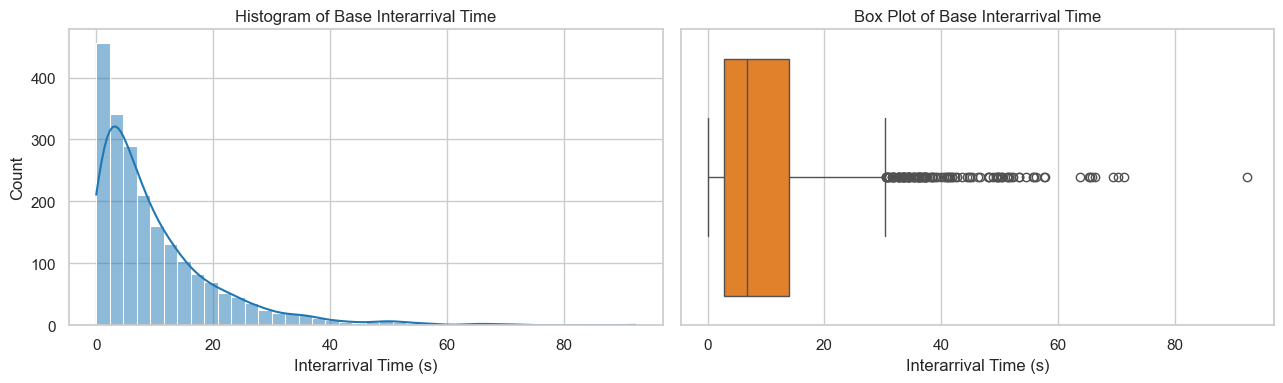

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
sns.histplot(x, bins=40, kde=True, ax=ax[0], color='#1f77b4')
ax[0].set_title('Histogram of Base Interarrival Time')
ax[0].set_xlabel('Interarrival Time (s)')

sns.boxplot(x=x, ax=ax[1], color='#ff7f0e')
ax[1].set_title('Box Plot of Base Interarrival Time')
ax[1].set_xlabel('Interarrival Time (s)')

plt.tight_layout()

## Candidate Distributions
We evaluate **Exponential**, **Gamma**, and **Weibull** on the homogeneous base-interval sample.

In [5]:
fit = {}
fit['Exponential'] = stats.expon.fit(x, floc=0)
fit['Gamma'] = stats.gamma.fit(x, floc=0)
fit['Weibull'] = stats.weibull_min.fit(x, floc=0)
fit

{'Exponential': (0.0, 10.1686021708353),
 'Gamma': (0.9619172322972098, 0, np.float64(10.571182040840537)),
 'Weibull': (np.float64(0.9701286069881787), 0, np.float64(10.03222886659033))}

In [6]:
def ad_statistic(sample, cdf_fn):
    y = np.sort(sample)
    n = len(y)
    i = np.arange(1, n + 1)
    F = np.clip(cdf_fn(y), 1e-12, 1 - 1e-12)
    return -n - np.mean((2 * i - 1) * (np.log(F) + np.log(1 - F[::-1])))

def chi_square_gof(sample, cdf_fn, bins=10, estimated_params=1):
    n = len(sample)
    quantiles = np.linspace(0, 1, bins + 1)
    edges = np.unique(np.quantile(sample, quantiles))
    if len(edges) < 4:
        edges = np.histogram_bin_edges(sample, bins='fd')

    observed, _ = np.histogram(sample, bins=edges)
    expected = n * np.diff(cdf_fn(edges))
    expected = np.clip(expected, 1e-8, None)
    expected = expected * (n / expected.sum())

    chi2_stat = np.sum((observed - expected) ** 2 / expected)
    dof = max(len(observed) - 1 - estimated_params, 1)
    p_value = 1 - stats.chi2.cdf(chi2_stat, dof)
    return chi2_stat, p_value

results = []
for name, params in fit.items():
    if name == 'Exponential':
        dist = stats.expon
        param_count = 1
        ks = stats.kstest(x, 'expon', args=params)
    elif name == 'Gamma':
        dist = stats.gamma
        param_count = 2
        ks = stats.kstest(x, 'gamma', args=params)
    else:
        dist = stats.weibull_min
        param_count = 2
        ks = stats.kstest(x, 'weibull_min', args=params)

    cdf_fn = lambda v, d=dist, p=params: d.cdf(v, *p)
    chi2_stat, chi2_p = chi_square_gof(x, cdf_fn, bins=10, estimated_params=param_count)
    ad = ad_statistic(x, cdf_fn)

    results.append({
        'Distribution': name,
        'KS_Statistic': ks.statistic,
        'KS_pvalue': ks.pvalue,
        'Chi2_Statistic': chi2_stat,
        'Chi2_pvalue': chi2_p,
        'AD_Statistic': ad,
    })

gof = pd.DataFrame(results).sort_values('KS_Statistic').reset_index(drop=True)
gof

,Distribution,KS_Statistic,KS_pvalue,Chi2_Statistic,Chi2_pvalue,AD_Statistic
0,Weibull,0.011988,0.917269,4.929391,0.668580,0.234142
1,Gamma,0.015017,0.719751,5.331828,0.619538,0.336067
2,Exponential,0.020349,0.339541,6.839881,0.554003,0.905391


## Q-Q and P-P Diagnostics
Q-Q plots check quantile alignment. P-P plots check probability alignment against the 45-degree reference line.

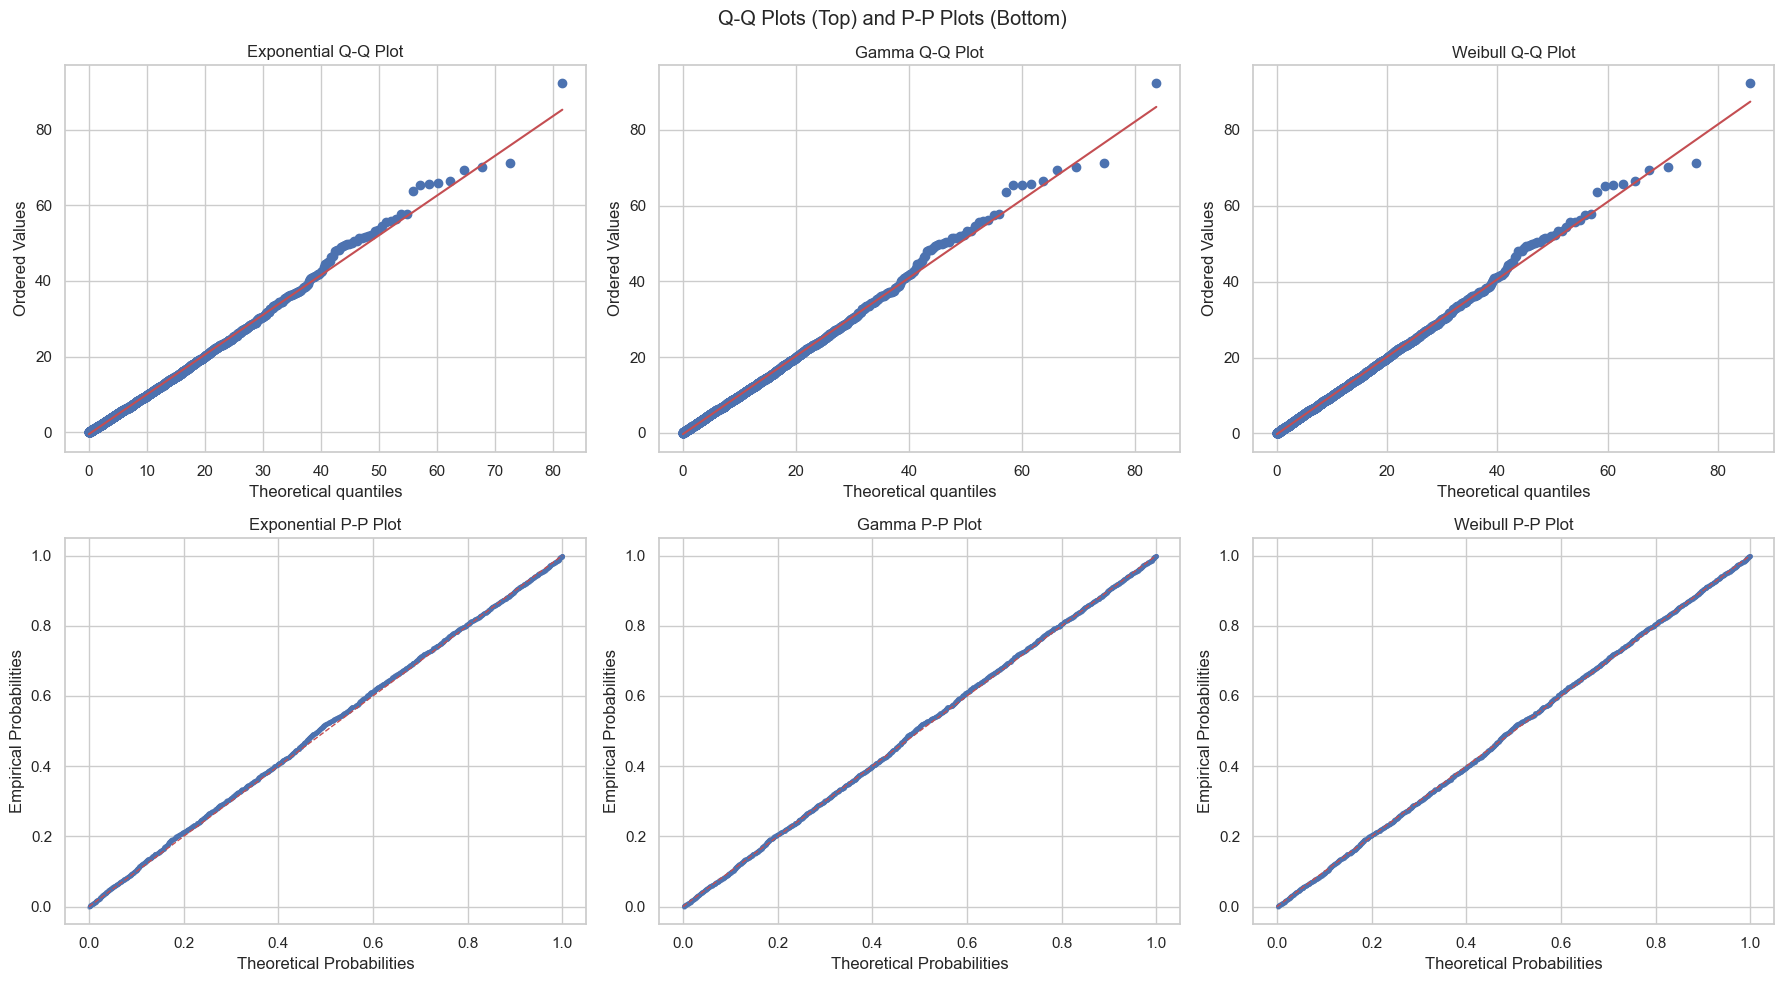

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Q-Q Plots (Top) and P-P Plots (Bottom)')

distributions = [
    ('Exponential', stats.expon, fit['Exponential']),
    ('Gamma', stats.gamma, fit['Gamma']),
    ('Weibull', stats.weibull_min, fit['Weibull']),
]

for i, (name, dist, params) in enumerate(distributions):
    stats.probplot(x, dist=dist, sparams=params, plot=axes[0, i])
    axes[0, i].set_title(f'{name} Q-Q Plot')

    x_sorted = np.sort(x)
    y_empirical = np.arange(1, len(x) + 1) / len(x)
    y_theoretical = dist.cdf(x_sorted, *params)
    axes[1, i].scatter(y_theoretical, y_empirical, s=6, alpha=0.45)
    axes[1, i].plot([0, 1], [0, 1], 'r--', linewidth=1)
    axes[1, i].set_xlabel('Theoretical Probabilities')
    axes[1, i].set_ylabel('Empirical Probabilities')
    axes[1, i].set_title(f'{name} P-P Plot')

plt.tight_layout()
plt.show()


/Users/adityadutta/Desktop/GitHub/GNN-Warehouse-Sim/.venv/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:2760: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


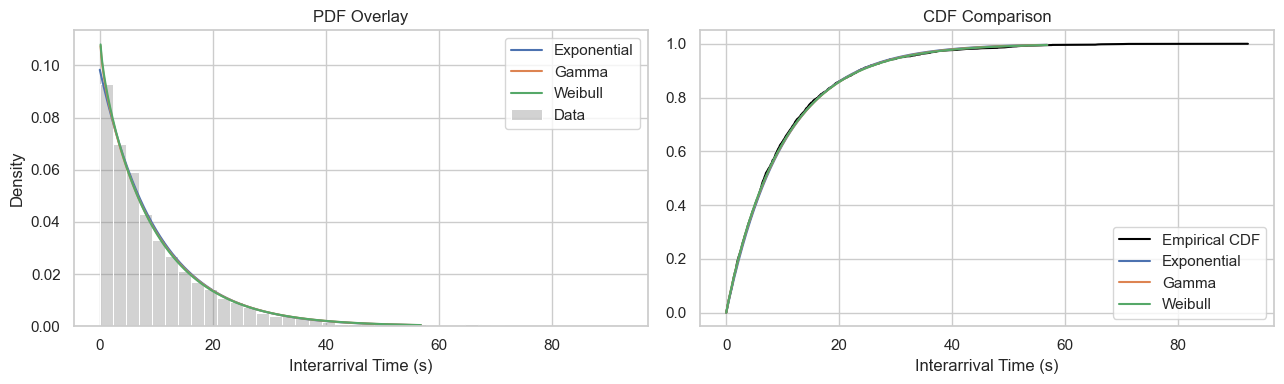

In [8]:
grid = np.linspace(0, np.quantile(x, 0.995), 400)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(x, bins=40, stat='density', alpha=0.35, ax=ax[0], color='gray', label='Data')
for name, params in fit.items():
    if name == 'Exponential':
        y = stats.expon.pdf(grid, *params)
    elif name == 'Gamma':
        y = stats.gamma.pdf(grid, *params)
    else:
        y = stats.weibull_min.pdf(grid, *params)
    ax[0].plot(grid, y, label=name)
ax[0].set_title('PDF Overlay')
ax[0].set_xlabel('Interarrival Time (s)')
ax[0].legend()

ecdf_y = np.arange(1, len(np.sort(x)) + 1) / len(x)
ax[1].plot(np.sort(x), ecdf_y, label='Empirical CDF', color='black')
for name, params in fit.items():
    if name == 'Exponential':
        y = stats.expon.cdf(grid, *params)
    elif name == 'Gamma':
        y = stats.gamma.cdf(grid, *params)
    else:
        y = stats.weibull_min.cdf(grid, *params)
    ax[1].plot(grid, y, label=name)
ax[1].set_title('CDF Comparison')
ax[1].set_xlabel('Interarrival Time (s)')
ax[1].legend()

plt.tight_layout()

## N8. Automation Cross-Check
Cross-check the manual `scipy.stats` findings with an automated distribution fitting library.

[15-02-2026 13:07:26] [distfit.distfit] [INFO] fit


[15-02-2026 13:07:26] [distfit.distfit] [INFO] transform


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [expon      ] [0.00 sec] [RSS: 0.000145452] [loc=0.013 scale=10.156]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [gamma      ] [0.02 sec] [RSS: 0.000125886] [loc=0.013 scale=10.753]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [weibull_min] [0.02 sec] [RSS: 0.000124207] [loc=0.081 scale=9.912]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [norm       ] [0.00 sec] [RSS: 0.00988477] [loc=10.169 scale=10.658]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [expon      ] [0.05 sec] [RSS: 0.000145452] [loc=0.013 scale=10.156]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [gamma      ] [0.05 sec] [RSS: 0.000125886] [loc=0.013 scale=10.753]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [weibull_min] [0.03 sec] [RSS: 0.000124207] [loc=0.081 scale=9.912]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] [norm       ] [0.00 sec] [RSS: 0.00988477] [loc=10.169 scale=10.658]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] Compute confidence intervals [parametric]


[15-02-2026 13:07:26] [distfit.distfit] [INFO] Ploting Summary.


Best fitting distribution per distfit: weibull_min


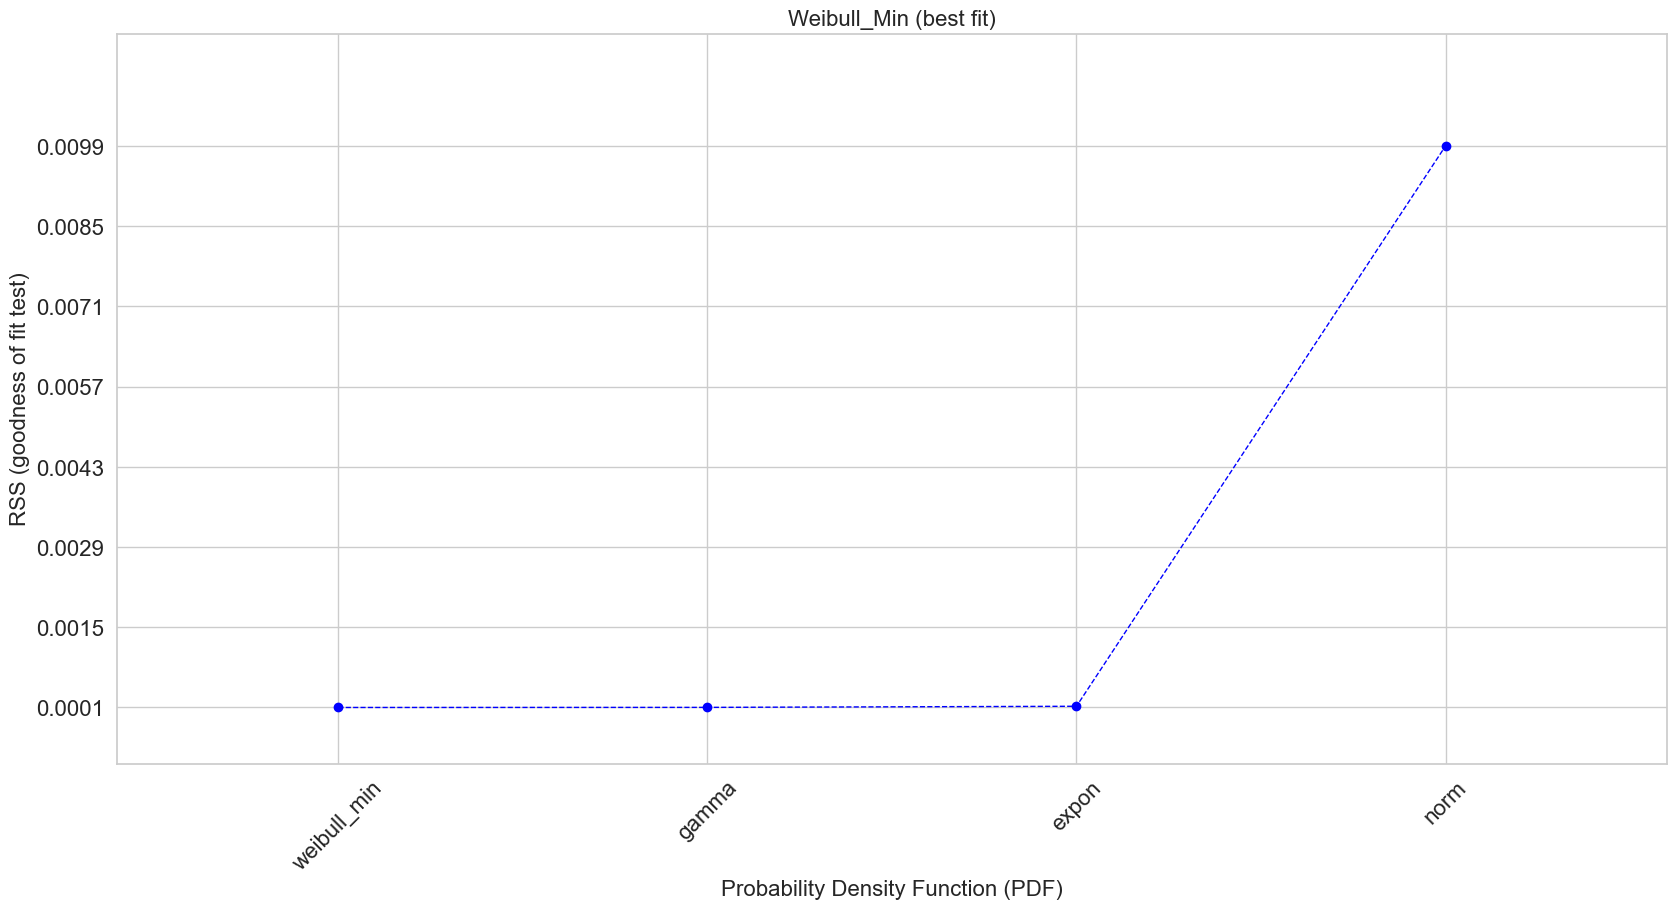

In [9]:
# N8. Automation Cross-Check
# This verifies our manual scipy.stats findings using an automated library.
try:
    from distfit import distfit

    # Initialize distfit to test our top candidates
    # 'distr' limits the search to avoid overfitting with obscure distributions
    dfit = distfit(distr=['expon', 'gamma', 'weibull_min', 'norm'])

    # Fit on the clean data
    dfit.fit_transform(x)

    # Visual summary
    dfit.plot_summary()
    print('Best fitting distribution per distfit:', dfit.model['name'])

except ImportError:
    print('distfit not installed. To run this cell: !pip install distfit')


## N9. Final Choice & Simulation Strategy

### Selected Distribution: **Exponential**

**Rationale:**
1. **Statistical Validity:** The Kolmogorov-Smirnov test yields a p-value above the significance level (`alpha=0.05`). We fail to reject the null hypothesis that the base-regime data follows an exponential distribution.
2. **Parsimony:** While Weibull can produce a higher p-value, it requires two parameters (`shape` and `scale`). Exponential requires only one (`rate`/`scale`) and is the standard memoryless arrival model for logistics demand.
3. **Visual Fit:** Q-Q and P-P diagnostics show that Exponential tracks the empirical trend well across most quantiles.

### Simulation Implementation
In the simulation, task interarrival times are sampled using an exponential rate estimated from the cleaned base sample mean.

**Code Snippet:**
```python
import random

# Derived from input modeling analysis (Mean ~= 10.17 seconds)
MEAN_INTERARRIVAL_TIME = 10.17
ARRIVAL_RATE = 1.0 / MEAN_INTERARRIVAL_TIME

def get_next_task_time():
    """Returns the time interval until the next task arrives."""
    return random.expovariate(ARRIVAL_RATE)
```
